In [1]:
import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
from time import time
import io
import re

import pickle
from csv import reader
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import layers
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import plot_model

# physical_devices = tf.config.list_physical_devices('GPU') 
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

from datetime import datetime
from collections import defaultdict

from sklearn.model_selection import train_test_split



In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from transformers import TFAlbertForSequenceClassification, AlbertTokenizer

# Data Exploration

In [5]:
train_section = pd.read_table("train_dataset.csv", sep='\t', index_col=0)
val_section = pd.read_table("val_dataset.csv", sep='\t', index_col=0)
test_section = pd.read_table("test_dataset.csv", sep='\t', index_col=0)

<AxesSubplot:>

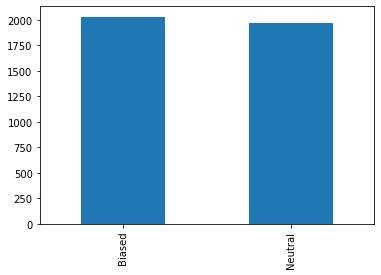

In [6]:
train_section["label"].value_counts().plot.bar()

<AxesSubplot:>

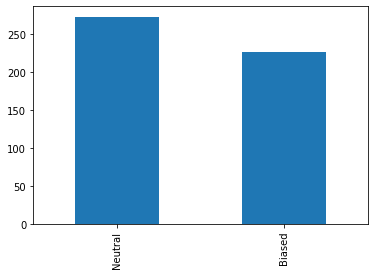

In [7]:
val_section["label"].value_counts().plot.bar()

<AxesSubplot:>

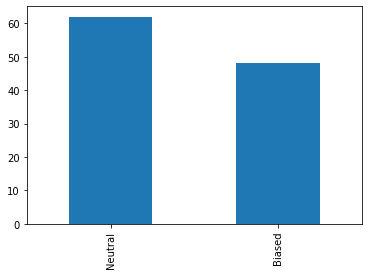

In [8]:
test_section["label"].value_counts().plot.bar()

## Hyperparameters

In [9]:
MAX_LEN = 512
nepochs = 50
nbatch = 16

In [10]:
data_dir = "./data"
log_dir = f"{data_dir}/experiments/logs"
save_path = f"{data_dir}/experiments/BinaryAlbertmodels"
cache_path_train = f"{data_dir}/cache/BinaryAlbertmodel.train"
cache_path_test = f"{data_dir}/cache/BinaryAlbertmodel.test"

## Transforming Data

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels = np.asarray(le.fit_transform(train_section['label']))
val_labels = np.asarray(le.transform(val_section['label']))

In [12]:
# le.inverse_transform(val_labels)[:20]

In [13]:
len(np.unique(train_labels))

2

In [14]:
tokenizer_transformer = AlbertTokenizer.from_pretrained('albert-large-v2')

In [15]:

def create_input_array(df, tokenizer):
    sentences = df.text.values

    input_ids = []
    attention_masks = []
    token_type_ids = []

    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
            sent,  # Sentence to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=MAX_LEN,  # Pad & truncate all sentences.
                pad_to_max_length=True,
                return_attention_mask=True,  # Construct attn. masks.
                return_tensors='tf',  # Return tf tensors.
            )

        # Add the encoded sentence to the list.
        input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

        token_type_ids.append(encoded_dict['token_type_ids'])

    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    token_type_ids = tf.convert_to_tensor(token_type_ids)


    return input_ids, attention_masks, token_type_ids
#     return input_ids, attention_masks



In [16]:
train_inputs = [create_input_array(train_section, tokenizer=tokenizer_transformer)]
val_inputs = [create_input_array(val_section, tokenizer=tokenizer_transformer)]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2068: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [17]:
def convert_inputs_to_tf_dataset(inputs):
    # args.max_seq_len = 256
    ids = inputs[0][0]
    masks = inputs[0][1]
    token_types = inputs[0][2]

    ids = tf.reshape(ids, (-1, MAX_LEN))
    print("Input ids shape: ", ids.shape)
    masks = tf.reshape(masks, (-1, MAX_LEN))
    print("Input Masks shape: ", masks.shape)
    token_types = tf.reshape(token_types, (-1, MAX_LEN))
    print("Token type ids shape: ", token_types.shape)

    ids=ids.numpy()
    masks = masks.numpy()
    token_types = token_types.numpy()
#     return[ids]
    return [ids, masks, token_types]
#     return [ids, masks]

In [18]:
train_data = convert_inputs_to_tf_dataset(train_inputs)
val_data = convert_inputs_to_tf_dataset(val_inputs)

Input ids shape:  (4000, 512)
Input Masks shape:  (4000, 512)
Token type ids shape:  (4000, 512)
Input ids shape:  (500, 512)
Input Masks shape:  (500, 512)
Token type ids shape:  (500, 512)


In [19]:
train_data

[array([[    2,  1033,    13, ...,  4664,  1526,     3],
        [    2,    44,   863, ...,    36,   954,     3],
        [    2,   191, 12730, ...,   144,    86,     3],
        ...,
        [    2,  1033,    13, ...,    19,    14,     3],
        [    2,  1267,    81, ...,    15,    56,     3],
        [    2,  3324,    19, ...,     0,     0,     0]], dtype=int32),
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)]

In [20]:
model = TFAlbertForSequenceClassification.from_pretrained("albert-large-v2", num_labels=len(np.unique(train_labels)))


All model checkpoint layers were used when initializing TFAlbertForSequenceClassification.

Some layers of TFAlbertForSequenceClassification were not initialized from the model checkpoint at albert-large-v2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
model.summary()

Model: "tf_albert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
albert (TFAlbertMainLayer)   multiple                  17683968  
_________________________________________________________________
dropout_4 (Dropout)          multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  2050      
Total params: 17,686,018
Trainable params: 17,686,018
Non-trainable params: 0
_________________________________________________________________


In [22]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-07, epsilon=1e-08)

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
history = model.fit(x = train_data, 
          y = train_labels,
          validation_data= (val_data, val_labels), 
          epochs = 25, 
          batch_size = 5)

Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
800/800 [==============================] - 322s 385ms/step - loss: 0.7158 - accuracy: 0.4920 - val_loss: 0.6868 - val_accuracy: 0.5640
Epoch 2/25
800/800 [==============================] - 312s 390ms/step - loss: 0.6788 - accuracy: 0.5761 - val_lo

KeyboardInterrupt: 

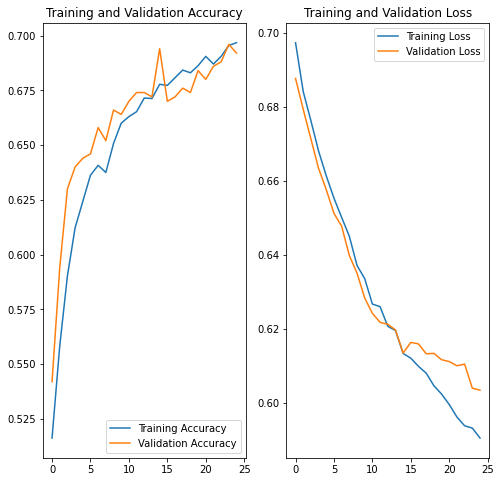

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
# plt.show()
plt.savefig('albertlargebinary.jpg')

In [25]:
albertmodeldata = pd.DataFrame(list(zip(acc, val_acc, loss, val_loss)),
               columns =['Accuracy', 'ValAccuracy', 'Loss', 'Val_loss'])
albertmodeldata.head()

,Accuracy,ValAccuracy,Loss,Val_loss
0,0.51625,0.542,0.697309,0.687656
1,0.55825,0.594,0.684102,0.679301
2,0.59025,0.630,0.676242,0.671327
3,0.61225,0.640,0.668031,0.663350
4,0.62425,0.644,0.661337,0.657615


In [26]:
albertmodeldata.to_csv("albertmodeldata.csv", sep='\t')

In [27]:
test_section.shape

(110, 16)

In [28]:
test_section = test_section[:110]
test_section.shape

(110, 16)

In [29]:
test_labels = np.asarray(le.transform(test_section['label']))
test_inputs = [create_input_array(test_section, tokenizer=tokenizer_transformer)]
test_data = convert_inputs_to_tf_dataset(test_inputs)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2068: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Input ids shape:  (110, 512)
Input Masks shape:  (110, 512)
Token type ids shape:  (110, 512)


In [30]:
print("Evaluate on test data")
results = model.evaluate(test_data, test_labels, batch_size=5)
print("test loss, test acc:", results)


Evaluate on test data
22/22 [==============================] - 3s 119ms/step - loss: 0.6187 - accuracy: 0.6545
test loss, test acc: [0.61870938539505, 0.6545454263687134]


In [31]:
# predict probabilities for test set
test_probs = model.predict(test_data, batch_size= 1, verbose=0)

In [32]:
test_probs = test_probs["logits"]

In [33]:
test_classes = np.argmax(test_probs, axis = 1)

In [34]:
test_classes

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0])

In [35]:
test_labels

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0])

In [36]:
c=0
for i in range(test_classes.shape[0]):
    if test_classes[i]==test_labels[i]:
        c+=1
print("Test accuracy:")
print(c/test_labels.shape[0])

Test accuracy:
0.6545454545454545


In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [38]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_labels, test_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(test_labels, test_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_labels, test_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels, test_classes)
print('F1 score: %f' % f1)
 

Accuracy: 0.654545
Precision: 0.687500
Recall: 0.709677
F1 score: 0.698413


In [39]:
# train_section.to_csv("train_dataset.csv", sep='\t')
# val_section.to_csv("val_dataset.csv", sep='\t')
# test_section.to_csv("test_dataset.csv", sep='\t')

In [40]:
model.save_pretrained(save_path)

In [41]:
tf.keras.backend.clear_session()